In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
results_df = pd.read_csv('data/13_estimation_results/kalimantan_multiple_models_cross_validation_results_sorted.csv')
len(results_df)

1624

In [2]:
results_df

NameError: name 'results_df' is not defined

In [4]:
summary_stats = results_df[['r2_score', 'rmse', 'pearson_r']].describe()
summary_stats

,r2_score,rmse,pearson_r
count,1.624000e+03,1.624000e+03,1624.000000
mean,-2.838947e+16,8.363548e+08,0.406950
std,4.311025e+17,1.238863e+10,0.337436
min,-6.578552e+18,4.837324e+00,-0.851329
25%,-1.244857e+00,1.190475e+01,0.189401
50%,-1.333103e-01,2.753088e+01,0.434273
75%,2.764167e-01,9.173367e+01,0.670528
max,9.856833e-01,1.889076e+11,0.994152


In [6]:
# Performance by model type
model_performance = results_df.groupby('estimator_name')[['r2_score', 'rmse', 'pearson_r']].mean()
model_performance

,r2_score,rmse,pearson_r
estimator_name,,,
GradientBoostingRegressor,-2.210431e+00,4.819924e+01,0.478301
LinearRegression,-1.135579e+17,3.345419e+09,0.297262
RandomForestRegressor,-1.621352e+00,4.784604e+01,0.494851
Sequential,-1.068150e+02,8.196358e+01,0.357385


In [7]:
# Analyze performance by split type
split_performance = results_df.groupby('validation')[['r2_score', 'rmse', 'pearson_r']].mean()
split_performance


,r2_score,rmse,pearson_r
validation,,,
cross validation id,-7.484497e+16,2.204933e+09,0.361141
cross validation month,-7.814095e-02,4.013778e+01,0.569833
cross validation year,-7.781997e+05,2.621706e+03,0.274251


In [8]:
# Analyze performance by split type
split_performance = results_df.groupby('validation')[['r2_score', 'rmse', 'pearson_r']].mean()
split_performance


,r2_score,rmse,pearson_r
validation,,,
cross validation id,-7.484497e+16,2.204933e+09,0.361141
cross validation month,-7.814095e-02,4.013778e+01,0.569833
cross validation year,-7.781997e+05,2.621706e+03,0.274251


In [16]:
# Calculating mean R2 and RMSE for each PHU
phu_split_performance = results_df.groupby(['phu_id', 'validation']).agg({
    'r2_score': 'mean',
    'rmse': 'mean',
    'no_obs': 'sum'  # Total number of observations for each PHU
}).reset_index()
# Sort by R2 score
phu_split_performance.sort_values(by='r2_score', ascending=False, inplace=True)
# don't show the exponential notation
pd.options.display.float_format = '{:.4f}'.format
phu_split_performance.head()

best_phus= list(phu_split_performance.head(5)["phu_id"].unique())
best_phus

[297.0, 351.0, 357.0, 350.0, 256.0]

In [24]:
phu_split_performance.head(25)


,phu_id,validation,r2_score,rmse,no_obs
9,297.0000,cross validation month,0.7314,12.4888,6360
23,351.0000,cross validation month,0.7294,28.7911,40280
29,357.0000,cross validation month,0.7191,44.8502,6920
20,350.0000,cross validation month,0.6465,52.8559,19240
5,256.0000,cross validation id,0.3746,6.2859,33960
16,340.0000,cross validation id,0.3212,6.7373,61840
26,352.0000,cross validation month,0.3203,81.5337,8832
10,297.0000,cross validation year,0.1065,21.3562,3816
45,407.0000,cross validation id,0.0494,9.9462,8000
24,351.0000,cross validation year,0.0270,48.6434,40280


## Train the model

In [12]:
from gee_scripts.parameters import explain_vars
from gee_scripts.models import get_random_forest, get_regressors
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error
from gee_scripts.plots import plot_observed_vs_predicted

import seaborn as sns


Earth Engine initialized successfully, with ee-indonesia-gwl


2024-06-19 16:14:22.317413: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-19 16:14:22.318968: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 16:14:22.347733: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 16:14:22.348290: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 16:14:22.837084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [13]:
df = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])
len(df)

32783

In [17]:
data = df[df.phu_id.isin(best_phus)]
len(data)

2669

In [18]:
data.shape[1]

50

/tmp/ipykernel_899177/831175479.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_df['Target'] = data["gwl_cm"]


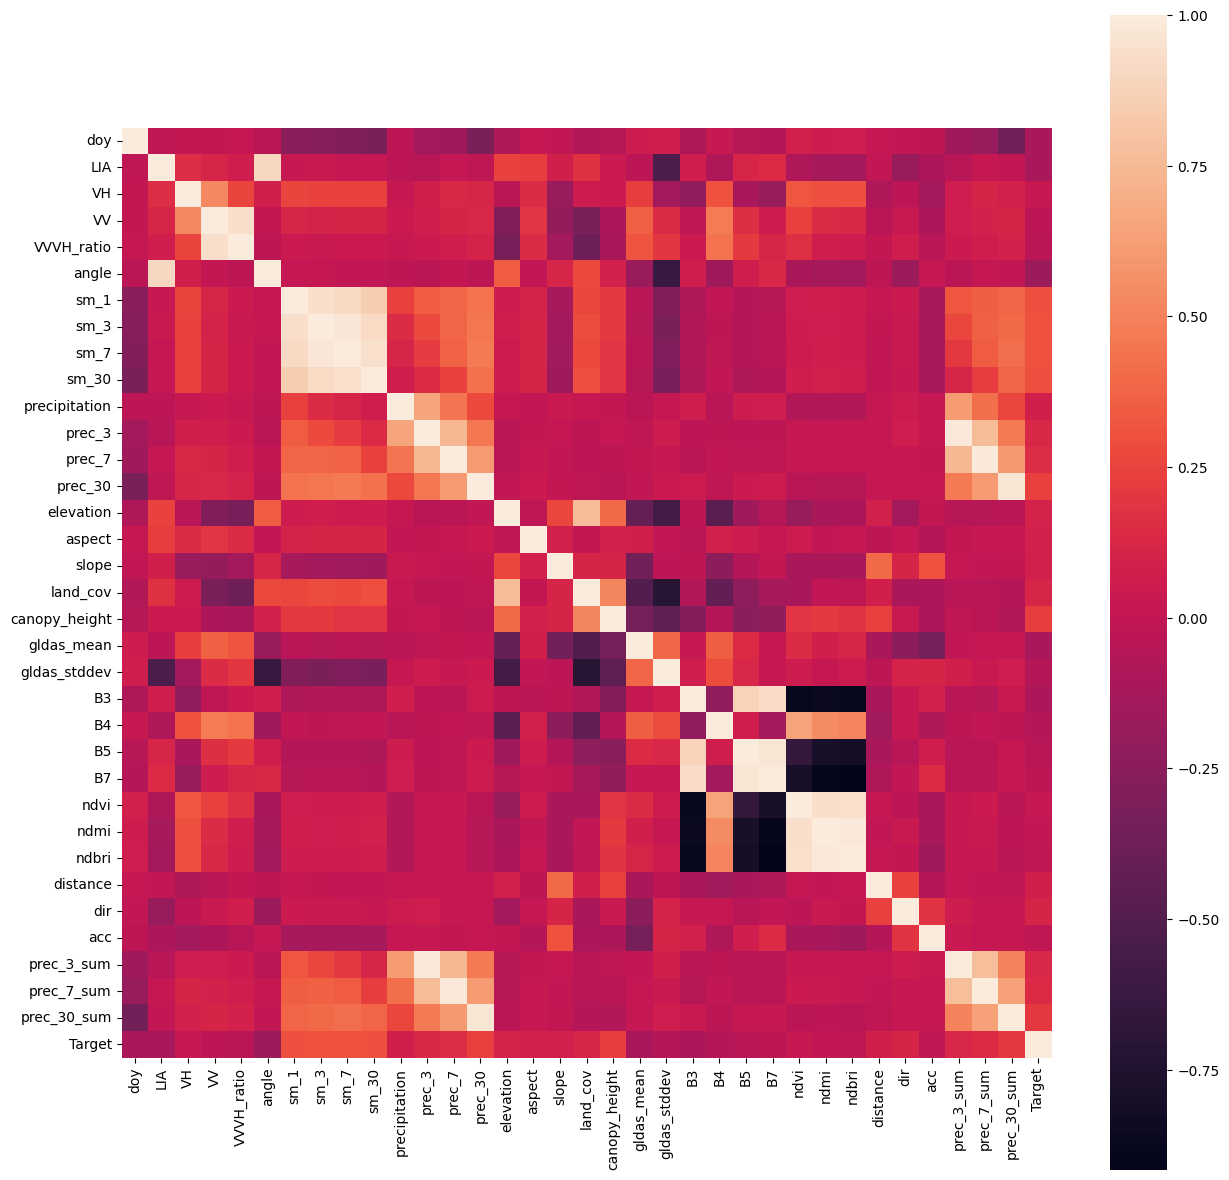

In [19]:
corr_df = data[explain_vars]
corr_df['Target'] = data["gwl_cm"]

C_mat = corr_df.corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, square = True)
plt.show()

lenght of train and test 1911 758
r2_score: 0.6941809433039839
rmse: 35.523198319493396
pearson r: 0.8360787156734824
p-value: 2.649192890454087e-199


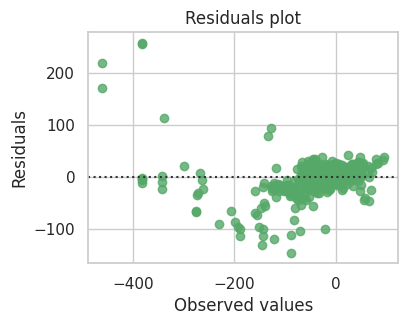

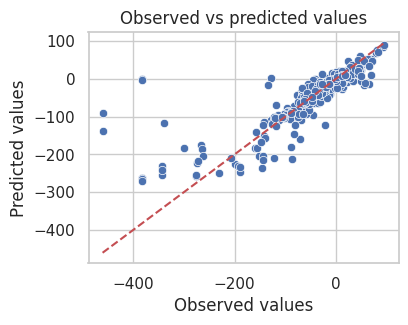

In [20]:
# PCA TEST
# Divide train and test by PCA and year
# train_data = data[data["date"].dt.year.isin([2020,2021,2022])]
# test_data = data[data["date"].dt.year.isin([2023])]

# # Divide train and test by PCA and month


train_data = data[data["date"].dt.month.isin([1,2,4,5,7,8,10,11,12])]
test_data = data[data["date"].dt.month.isin([3,6,9,])]

X_train, X_test = train_data[explain_vars], test_data[explain_vars]
y_train, y_test = train_data["gwl_cm"], test_data["gwl_cm"]

print("lenght of train and test", len(X_train), len(X_test))

####################### TRAIN

regr = get_random_forest()

regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)

r, p = pearsonr(y_test, y_pred_test)
r2_score_val = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print all the metrics
print(f"r2_score: {r2_score_val}")
print(f"rmse: {rmse}")
print(f"pearson r: {r}")
print(f"p-value: {p}")

plot_observed_vs_predicted(y_test, y_pred_test, "Observed vs Predicted GWL")


lenght of train and test 2135 534
r2_score: 0.7670312791753721
rmse: 30.00945218730938
pearson r: 0.8773769945960909
p-value: 8.321242449299339e-172


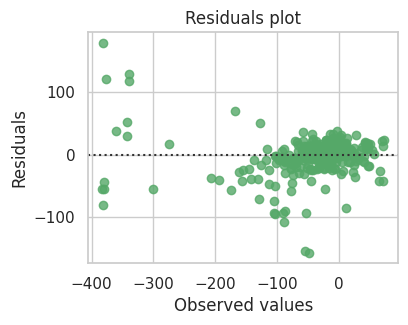

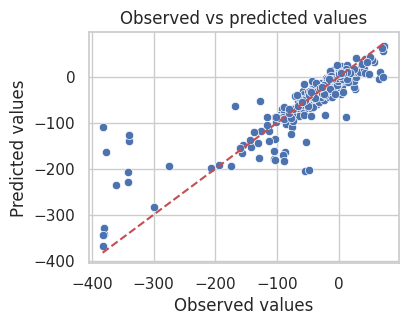

In [25]:
# divide test/train by random sampling
train_data = data.sample(frac=0.8)
test_data = data.drop(train_data.index)

X_train, X_test = train_data[explain_vars], test_data[explain_vars]
y_train, y_test = train_data["gwl_cm"], test_data["gwl_cm"]

print("lenght of train and test", len(X_train), len(X_test))

####################### TRAIN

regr = get_random_forest()

regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)

r, p = pearsonr(y_test, y_pred_test)
r2_score_val = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print all the metrics
print(f"r2_score: {r2_score_val}")
print(f"rmse: {rmse}")
print(f"pearson r: {r}")
print(f"p-value: {p}")

plot_observed_vs_predicted(y_test, y_pred_test, "Observed vs Predicted GWL")


In [21]:
from gee_scripts.models import bootstrap

In [22]:
bootrap_result = bootstrap(data, "gwl_cm", 20, 0.8, explain_vars)
bootrap_result

Training with 2669 observations


,mean,min,max,median
r,0.8772,0.7837,0.9331,0.8820
r2,0.7611,0.6124,0.8620,0.7671
rmse,30.2753,21.7647,38.8964,30.1774
samples_train,2135.0000,2135.0000,2135.0000,NaN
samples_test,534.0000,534.0000,534.0000,NaN
